In [1]:
from structured.DataRetriever import DataRetriever
import numpy as np
import pandas as pd

dt = DataRetriever("D:/Descargas/i2ascii-files/i2ascii-files/", 300)
dt.set_target(['m_elev','m_az'])
dt.set_selected_hits(10)
target, data, compare_data = dt.load_data(
    get_sel_events = False,
    filter_bbfit_null = False,
    get_bbfit_data = True,
    get_aafit_data = True
)

In [2]:
# En lugar de importar la función del script utilizado en clase, se reimplementa con ligeras variaciones para
# adaptarse a las necesidades del ejercicio
def grafica_real_vs_pred_mod(y_true, y_pred, evaluated_metrics, algorithm_name):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Real class value')
    ax.set_ylabel('Prediction')
    title = algorithm_name + '\n'
    for name, result in evaluated_metrics.items():
        title += name + ': ' + str(round(result, 3)) + ' '
        
    plt.title(title)
    plt.show()

In [3]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
    
rand_state = 50
jobs = 6

# Métricas de evaluación que se utilizarán. No nos preocupamos en negarlas debido a que no se utilizarán de forma automática,
# solo las visualizaremos
metrics_dict = {
  'MAE': metrics.mean_absolute_error,
  'RMSE': lambda y, y_pred:
          sqrt(metrics.mean_squared_error(y, y_pred)),
  'E_VARIANCE': metrics.explained_variance_score
}

algorithms_dict = {}

# Algoritmo 1: Standarización + RandomForest
steps = [
    ('standardization', StandardScaler()),
    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
algorithms_dict['STD_RF'] = Pipeline(steps)

# Algoritmo 2: Standarización + PCA + RandomForest
steps = [
    ('standardization', StandardScaler()),
    ('pca', PCA(random_state=rand_state)),
    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
algorithms_dict['STD_PCA_RF'] = Pipeline(steps)

# Algoritmo 3: Standarización + FeatureAgglomeration + RandomForest
steps = [
    ('standardization', StandardScaler()),
    ('feature_agg', FeatureAgglomeration()),
    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
algorithms_dict['STD_FEAT_RF'] = Pipeline(steps)

# Algoritmo 4: Standarización + LocallyLinearEmbedding + RandomForest
steps = [
    ('standardization', StandardScaler()),
    ('loc_lin_emb', LocallyLinearEmbedding(random_state=rand_state, n_jobs=jobs)),
    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
algorithms_dict['STD_LLE_RF'] = Pipeline(steps)

# Algoritmo 5: Standarización + SpectralEmbedding + RandomForest
#steps = [
#    ('standardization', StandardScaler()),
#    ('loc_spec_emb', SpectralEmbedding(random_state=rand_state, n_jobs=jobs)),
#    ('rforest', RandomForestRegressor(n_estimators=50, random_state=rand_state, n_jobs=jobs))]
#algorithms_dict['STD_SPEC_RF'] = Pipeline(steps)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=rand_state)

In [5]:
from structured.OutlierDetectionTransform import OutlierDetectionTransform

outDet = OutlierDetectionTransform()
outDet.set_random_state(rand_state)
outDet.set_jobs(jobs)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


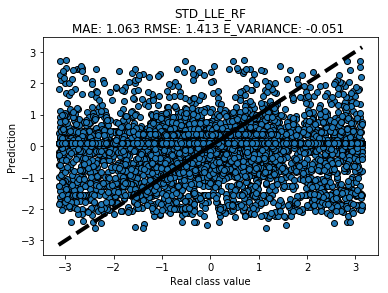

BBFIT OCSVM MAE: 1.063219094011794
BBFIT OCSVM RMSE: 1.4130725437587177
BBFIT OCSVM E_VARIANCE: -0.05056878832380163


In [20]:
outDet.set_OCSVM(coef0_val=0.0, gamma_val='scale', kernel_val='rbf', nu_val=0.4)
ocsvm_target, ocsvm_data = outDet.filter_data(y_train, X_train)

algorithms_dict['STD_LLE_RF'].fit(ocsvm_data, ocsvm_target)
y_pred = algorithms_dict['STD_LLE_RF'].predict(X_test)

evaluated = {}
for metric_name, metric in metrics_dict.items():
    evaluated[metric_name] = metric(y_test, y_pred)

grafica_real_vs_pred_mod(y_test, y_pred, evaluated, 'STD_LLE_RF')
    
print('BBFIT OCSVM MAE: ' + str(metrics_dict['MAE'](y_test, y_pred)))
print('BBFIT OCSVM RMSE: ' + str(metrics_dict['RMSE'](y_test, y_pred)))
print('BBFIT OCSVM E_VARIANCE: ' + str(metrics_dict['E_VARIANCE'](y_test, y_pred)))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were a

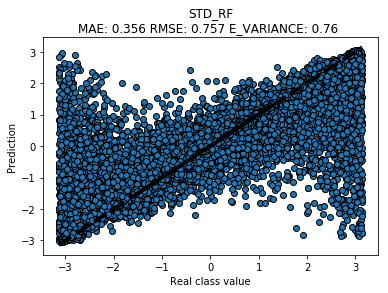

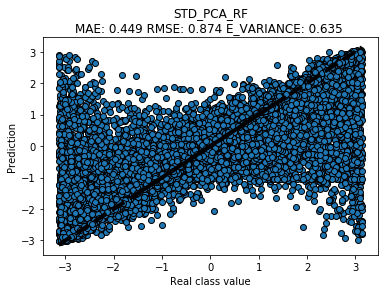

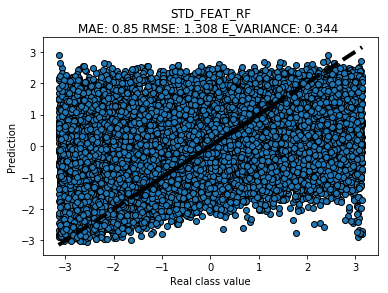

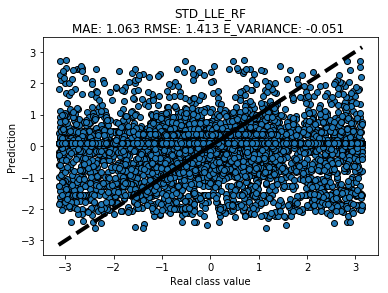

In [19]:
# Se realizan las 6 predicciones y se almacenan en un diccionario con nombres descriptivos 
y_pred_dict = {}
for alg_name, alg in algorithms_dict.items():
    outDet.set_OCSVM(coef0_val=0.0, gamma_val='scale', kernel_val='rbf', nu_val=0.4)
    ocsvm_target, ocsvm_data = outDet.filter_data(y_train, X_train)
    
    alg.fit(ocsvm_data, ocsvm_target)
    y_pred_dict[alg_name] = alg.predict(X_test)
    
evaluated = {}
for name, prediction in y_pred_dict.items():
    for metric_name, metric in metrics_dict.items():
        evaluated[metric_name] = metric(y_test, prediction)

    grafica_real_vs_pred_mod(y_test, prediction, evaluated, name)